In [1]:
from pulp import LpMinimize, LpProblem, LpStatus, lpSum, LpVariable
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime, timedelta

In [2]:
# T = 24
# availability_user1 = np.array([0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0])
# assert len(availability_user1) == T


max_charge_rate = float('inf')
offtake_price = 0.5e-3


In [3]:
a = [[1,2,3],[4,5,6,7]]
a[0][1]

2

In [ ]:
# Dom laden: op elk tijdsstip t vraagt elke auto die wilt laden, max vermogen. Als boven cap: verschil met cap/#ladende auto's aftrekken van geladen vermogen.
time = 24
cap = 10
#user[chargerate,maxcharge]
users = [

{"user":[5,50],"loadprof":[0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0],"demandprof": [30,40]},  #user = [maxrate,maxcapacity]
{"user":[4,70],"loadprof":[1,0,0,1,0,0,0,0,0,0,1,1,1,1,1,0,0,0,1,1,1,0,0,1],"demandprof": [10,20,60]}
]


def dumpProfile(userlist,timesteps):
    newprofs = [[] for user in range(userlist)]
    for t in range(timesteps):
        print(t)
        ls = 0
        for user in userlist:
            profile = newprofs[userlist.index(user)] 
            if user.get('loadprof')[t] == 0:
                profile.append(0)
            elif user.get('loadprof')[t] == 1:
                profile.append(user.get('user')[0])

    print(newprofs)
    print(len(newprofs[0]))

dumpProfile(users,time)




    




: 

In [4]:
model = LpProblem(name='laadpaalstudie', sense=LpMinimize)
Z = [2,3] #number of times the car is at the chargingstation within simulation period (T), Z = len(Tz)
T = 24 #timesteps in hour resolution
cap = 2000
C = 2 #number of charging stations
Tz = [[(2,4),(18,20)], [(3,4),(10,15),(19,22)]]
demand = [[3000,5000],[1000,2000,6000]]
priority = [1,1] #According to users: least priority gets 1, next 2, next 3,... len(priority) = C


zcharge = LpVariable.dicts('zcharge', [(c,z) for c in range(C) for z in range(Z[c])], lowBound=0, upBound=max_charge_rate)
tcharge = LpVariable.dicts('tcharge', [(c,t) for c in range(C) for t in range(T)], lowBound=0, upBound=max_charge_rate)

obj = lpSum([(demand[c][z] - zcharge[(c,z)])*priority[c] for c in range(C) for z in range(Z[c])])
model += obj


for t in range(T):
    model += (lpSum(tcharge[(c,t)] for c in range(C)) <= cap)
    
for c in range(C):
    for z in range(Z[c]):
        model += (zcharge[(c,z)] == lpSum([tcharge[(c,t)] for t in range(Tz[c][z][0],Tz[c][z][1])]))

        model += (zcharge[(c,z)] <= demand[c][z])



# Solve the problem
status = model.solve(use_mps=False)

print(f"status: {model.status}, {LpStatus[model.status]}")


print(f"objective: {model.objective.value()}")


for var in model.variables():
    print(f"{var.name}: {var.value()}")



status: 1, Optimal
objective: 7000.0
tcharge_(0,_0): 0.0
tcharge_(0,_1): 0.0
tcharge_(0,_10): 0.0
tcharge_(0,_11): 0.0
tcharge_(0,_12): 0.0
tcharge_(0,_13): 0.0
tcharge_(0,_14): 0.0
tcharge_(0,_15): 0.0
tcharge_(0,_16): 0.0
tcharge_(0,_17): 0.0
tcharge_(0,_18): 2000.0
tcharge_(0,_19): 0.0
tcharge_(0,_2): 2000.0
tcharge_(0,_20): 0.0
tcharge_(0,_21): 0.0
tcharge_(0,_22): 0.0
tcharge_(0,_23): 0.0
tcharge_(0,_3): 0.0
tcharge_(0,_4): 0.0
tcharge_(0,_5): 0.0
tcharge_(0,_6): 0.0
tcharge_(0,_7): 0.0
tcharge_(0,_8): 0.0
tcharge_(0,_9): 0.0
tcharge_(1,_0): 0.0
tcharge_(1,_1): 0.0
tcharge_(1,_10): 0.0
tcharge_(1,_11): 0.0
tcharge_(1,_12): 0.0
tcharge_(1,_13): 0.0
tcharge_(1,_14): 2000.0
tcharge_(1,_15): 0.0
tcharge_(1,_16): 0.0
tcharge_(1,_17): 0.0
tcharge_(1,_18): 0.0
tcharge_(1,_19): 2000.0
tcharge_(1,_2): 0.0
tcharge_(1,_20): 2000.0
tcharge_(1,_21): 2000.0
tcharge_(1,_22): 0.0
tcharge_(1,_23): 0.0
tcharge_(1,_3): 2000.0
tcharge_(1,_4): 0.0
tcharge_(1,_5): 0.0
tcharge_(1,_6): 0.0
tcharge_(1,_7)

In [5]:
# zcharge_arr = np.zeros([(c,z) for c in range(C) for z in range(Z[c])])
tcharge_arr = np.zeros((C,T))
for c in range(C):
    for t in range(T):
        tcharge_arr[(c,t)] = tcharge[(c,t)].value()
    # for z in range(Z[c]):
    #     zcharge_arr[(c,z)] = zcharge[(c,z)].value()

[   0.    0. 2000.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0. 2000.    0.    0.    0.    0.    0.] [   0.    0.    0. 2000.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0. 2000.    0.    0.    0.    0. 2000. 2000. 2000.    0.    0.]


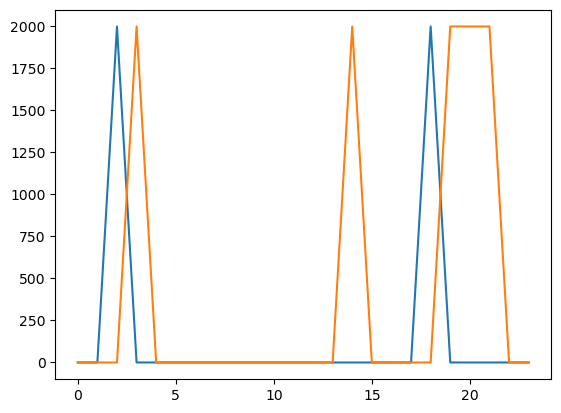

In [6]:
for c in range(C):
    plt.plot(tcharge_arr[c])
    # plt.plot(zcharge_arr[c])
print(tcharge_arr[0], tcharge_arr[1])
# print(zcharge_arr[1])

In [7]:
# Create the model
smodel = LpProblem(name="small-problem", sense=LpMinimize)

L = 500
G = np.array([450, 300, 400])

# # Initialize the decision variables
# x = LpVariable(name="x", lowBound=0)
# y = LpVariable(name="y", lowBound=0)

x0 = LpVariable.dicts('G1', range(2), lowBound=0)
x1 = LpVariable.dicts('G2', range(2), lowBound=0)


# Add the constraints to the model
T=2
for t in range(T):
    smodel += (x0[t] + x1[t] == L)
    smodel += (x0[t] <= G)
    smodel += (x1[t] <= G)

# Add the objective function to the model
obj_func = 0

for t in range(T):
    C0 = 200+50*x0[t]
    C1 = 300+30*x1[t]
    obj_func += C0 + C1
smodel += obj_func

# # Add the objective function to the model
# model += lpSum([x, 2 * y])

# Solve the problem
status = smodel.solve()

print(f"status: {smodel.status}, {LpStatus[smodel.status]}")


print(f"objective: {smodel.objective.value()}")


for var in smodel.variables():
    print(f"{var.name}: {var.value()}")


# for name, constraint in smodel.constraints.items():
#     print(f"{name}: {constraint.value()}")

status: 1, Optimal
objective: 31000.0
G1_0: 0.0
G1_1: 0.0
G2_0: 500.0
G2_1: 500.0
